# Convolutional Neural Networks and Image Classification

The image classification problem is the problem of assigning a label to an image. For example, we might want to assign the label "duck" to pictures of ducks, the label "frog" to pictures of frogs, and so on. 

In this lecture, we'll introduce some of the most important tools for image classification: convolutional neural networks. Major parts of this lecture are based on the "Images" tutorial [here](https://www.tensorflow.org/tutorials/images/cnn). 

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Convolutional neural network: picture

A convolutional neural network looks like 

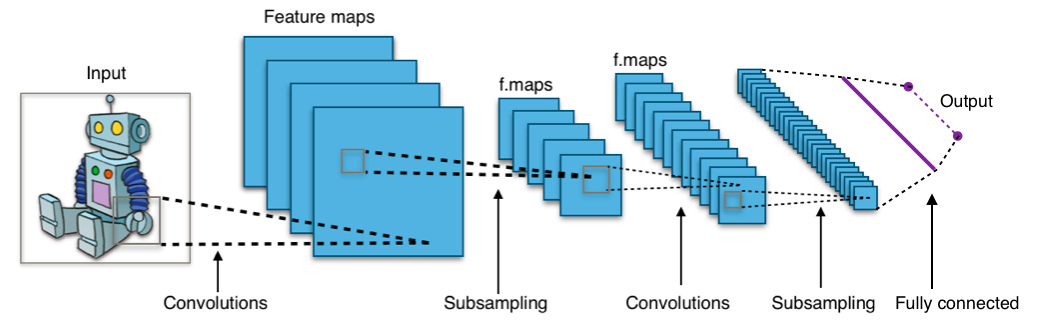



Before we use fully connected neural network, we need convolution layer and subsampling layer to extract useful features.

Let's prepare our dataset.

# Getting Data

For this lecture, we'll use a subset of the [CIFAR-10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). This data set can be conveniently accessed using a method from `tensorflow.keras.datasets`: 

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1. This helps the CNN learn faster and perform better.
train_images, test_images = train_images / 255.0, test_images / 255.0

There are 50,000 training images and 10,000 test images. Each image has 32x32 pixels, and there are three color "channels" -- red, green, and blue. 

In [3]:
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

There are 10 classes of image, encoded by the `labels` arrays. 

In [4]:
train_labels[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

Each class corresponds to a type of object: 

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Let's take a look. 

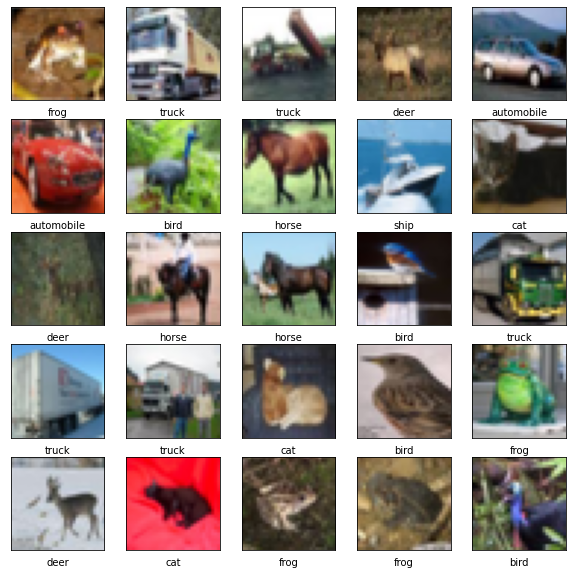

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Convolution


Convolution is a mathematical operation commonly used to extract *features* (meaningful properties) from images.

#### Convolution for edge detection

I want to use a toy example to explain that convolution can perform "edge detection" in a greyscale image.

Shape of training inputs (60000, 28, 28)
Shape of training labels (60000,)


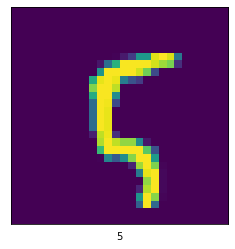

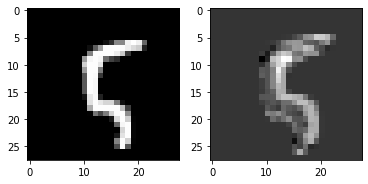

In [7]:
import keras
from keras.datasets import mnist

# import mnist dataset which contains handwritten digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# shape of each numpy array
print('Shape of training inputs', x_train.shape)
print('Shape of training labels', y_train.shape)


# visualize
idx = 100
x = x_train[idx,:,:]
y = y_train[idx]

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x)
plt.xlabel(y)
plt.show()

# define a kernel which is used to do convolution
kernel = np.array([[1, 1, 10], 
                   [-8,  0, -1], 
                   [9, 0, 0]])

from scipy.signal import convolve2d
convd = convolve2d(x, kernel, mode = "same")
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(x, cmap="gray")
axarr[1].imshow(convd, cmap="gray")

Observe that the convolved image (right) has darker patches corresponding to the distinct "edges" in the image, where darker colors meet lighter colors.

#### Convolution operation

The idea of image convolution is pretty simple. We define a *kernel* matrix containing some numbers, and we "slide it over" the input data. At each location, we multiply the data values by the kernel matrix values, and add them together. Here's an illustrative diagram: 

![](https://d2l.ai/_images/correlation.svg)

*Image from [Dive Into Deep Learning](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)*

The value of 19 in the output is obtained in this example by computing $0 \times 0 + 1 \times 1 + 3 \times 2 + 4 \times 3 = 19$. 


#### Convolution for colored images:

The idea is doing convolution operation for each color chanel and add obtained values together. See this [page](https://dev.to/sandeepbalachandran/machine-learning-convolution-with-color-images-2p41) for details.

#### Python commands

In tensorflow, we can construct convolution layer using `tf.keras.layers.Conv2D`, see documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D.


Example:

    conv = layers.Conv2D(filters = 32, kernel_size = (3, 3), 
                         strides = 1,
                         padding = 'valid'
                         activation='relu', 
                         input_shape=(32, 32, 3),
                         dilation_rate=1)
                         
- filters: integer, the dimensionality of the output space. In other words, the number of kernels applied to original picture.

- kernel_size: (1) you can use one number to specify all dimensions (2) you can use different numbers for height and width. Usually, we use (2,2), (3,3), (5,5).

- strides: integer or tuple/list of two integers, specifying the strides of the convolution along the height and width. I also call it step size.

- padding: "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. The default value is "valid".

- activation function: the default is no activation.

- input_shape: shape of input images.

- dilation_rate: when rate=1, this is the normal convolution. 
**Picture for explaining dialation_rate:**
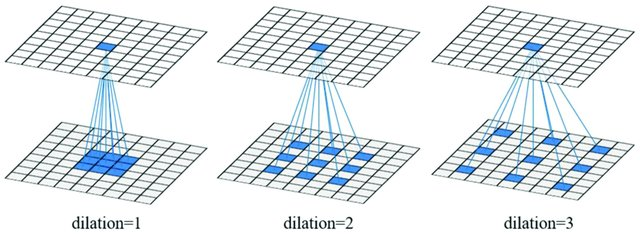

Kernels are trainable parameters which means we need to solve an optimization problem to find the optimal kernels for given training data points. Bias term is also allowed. The same initialization and regularization strategy also apply to Conv2D layer.


In [16]:
# example

data = np.arange(9).reshape(1,3,3,1)
kernel = np.arange(4).reshape(2,2,1,1)

img = tf.constant(data, dtype=float)
kernel = tf.constant(kernel, dtype=float)
tf.nn.conv2d(img, kernel, strides=[1,2,2,1],  padding="SAME")

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[19.],
         [10.]],

        [[ 7.],
         [ 0.]]]], dtype=float32)>

#### Learning Kernels

There are lots of convolutional kernels we could potentially use. How do we know which ones are meaningful? In practice, we don't. So, we treat them as parameters, and learn them from data as part of the model fitting process. This is exactly what the `Conv2d` layer allows us to do. 

In [8]:
conv = layers.Conv2D(32, (3, 3), 
                     activation='relu', 
                     input_shape=(32, 32, 3),
                     dtype = "float64")

(-0.5, 29.5, 29.5, -0.5)

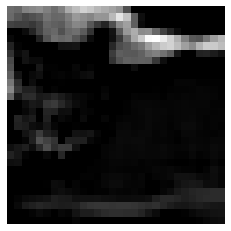

In [10]:
# pick an individual image while preserving dimensions
color_im = train_images[9:10]

# perform convolution and extract as numpy array
convd = conv(color_im).numpy()

# get a single feature (corresponding to one choice of convolution)
feature = convd[0,:,:,1]

plt.imshow(feature, cmap = "gray")
plt.gca().axis("off")

Let's compare a few other possibilities: 

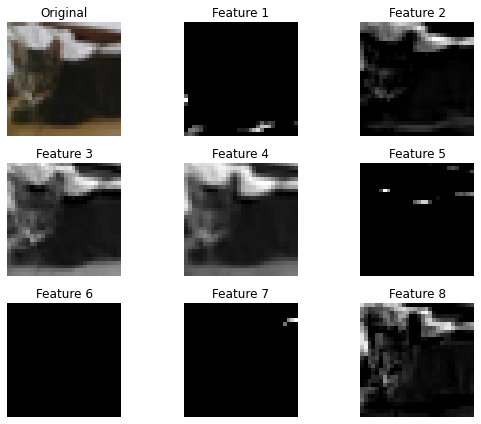

In [11]:
fig, axarr = plt.subplots(3, 3, figsize = (8, 6))

axarr[0, 0].imshow(color_im[0])
axarr[0,0].axis("off")
axarr[0,0].set(title = "Original")

i = 0
for ax in axarr.flatten()[1:]:
    ax.imshow(convd[0,:,:,i], cmap = "gray")
    i += 1
    ax.axis("off")
    ax.set(title = "Feature " + str(i))
    
plt.tight_layout()

These features may or may not be informative -- they are purely random! We can try to learn informative features by embedding these kernels in a model and optimizing. 

# Pooling:

What does pooling do? you can think of it as a kind of "summarization" step in which we intentionally make the current output somewhat "blockier." Technically, it involves sliding a window over the current batch of data and computing a new value based that window and different strategies. 

The advantage is saving computational power since we lower the shape of each feature.


Here's an example of max pooling: 

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

*Image credit: Computer Science Wiki*

Another pooling is average pooling:

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_1.51.40_PM.png)

*Image credit: Geeks for Geeks*

In [ ]:
# codes for max pooling:
tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs
)


# codes for average pooling:
tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs
)

In [2]:
# Verification 1:

data = np.array([12,20,30,0,8,12,2,0,34,70,37,4,112,100,25,12]).reshape(1,4,4,1)
tf.nn.max_pool2d(data, ksize=(2,2), strides=(1,2,2,1), padding="VALID")

<tf.Tensor: shape=(1, 2, 2, 1), dtype=int64, numpy=
array([[[[ 20],
         [ 30]],

        [[112],
         [ 37]]]])>

In [6]:
# verification 2:

data2 = np.array([31,15,28,184,0,100,70,38,12,12,7,2,12,12,45,6], dtype=float).reshape(1,4,4,1)
tf.nn.avg_pool2d(data2, ksize=(2,2), strides=(1,2,2,1), padding="VALID")

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float64, numpy=
array([[[[36.5],
         [80. ]],

        [[12. ],
         [15. ]]]])>

In [9]:
data = np.array([2,2,6,8,8,12,2,0,9,7,3,4,6,8,3,0]).reshape(1,4,4,1)
tf.nn.max_pool2d(data, ksize=(2,2), strides=(1,2,2,1), padding="VALID")

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[12.],
         [ 8.]],

        [[ 9.],
         [ 4.]]]], dtype=float32)>

## Building a Model

The most common approach is to alternate `Conv2D` layers with `MaxPooling2D` layers. Pooling layers act as "summaries" that reduce the size of the data at each step. After we're done doing "2D stuff" to the data, we then need to `Flatten` the data from 2d to 1d in order to pass it through the final `Dense` layers, which form the prediction. 

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10) # number of classes
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Let's train our model and see how it does! 

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, 
                    train_labels, 
                    epochs=10, 
                    batch_size = 64,
                    validation_data=(test_images, test_labels))

Epoch 1/10
782/782 [==============================] - 19s 24ms/step - loss: 1.5900 - accuracy: 0.4188 - val_loss: 1.4328 - val_accuracy: 0.4855
Epoch 2/10
782/782 [==============================] - 23s 29ms/step - loss: 1.2620 - accuracy: 0.5495 - val_loss: 1.1802 - val_accuracy: 0.5837
Epoch 3/10
782/782 [==============================] - 25s 31ms/step - loss: 1.1147 - accuracy: 0.6057 - val_loss: 1.0656 - val_accuracy: 0.6197
Epoch 4/10
782/782 [==============================] - 28s 35ms/step - loss: 1.0290 - accuracy: 0.6389 - val_loss: 1.0149 - val_accuracy: 0.6425
Epoch 5/10
782/782 [==============================] - 24s 31ms/step - loss: 0.9547 - accuracy: 0.6644 - val_loss: 1.0008 - val_accuracy: 0.6584
Epoch 6/10
782/782 [==============================] - 25s 32ms/step - loss: 0.8931 - accuracy: 0.6874 - val_loss: 0.9639 - val_accuracy: 0.6660
Epoch 7/10
782/782 [==============================] - 26s 34ms/step - loss: 0.8467 - accuracy: 0.7057 - val_loss: 0.9391 - val_accuracy:

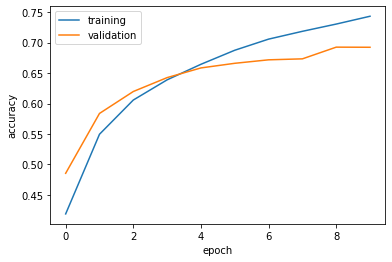

In [16]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

After just a few rounds of training, our model is able to guess the image label more than 50% of the time on the unseen validation data, which is relatively impressive considering that there are 10 possibilities. 

Note: the training process can often be considerably accelerated by training on a GPU. A limited amount of free GPU power is available via Google Colab, and is illustrated [here](https://colab.research.google.com/notebooks/gpu.ipynb). 

## Extracting Predictions

Let's see how our model did on the test data: 

In [85]:
y_pred = model.predict(test_images)
# Remember that I do not compute the probability here.
# To compute the probabilities, you should add softmax layer.
# I am only interested in the predicted labels
labels_pred = y_pred.argmax(axis = 1)

We'll plot these predicted labels along side the (true labels). 

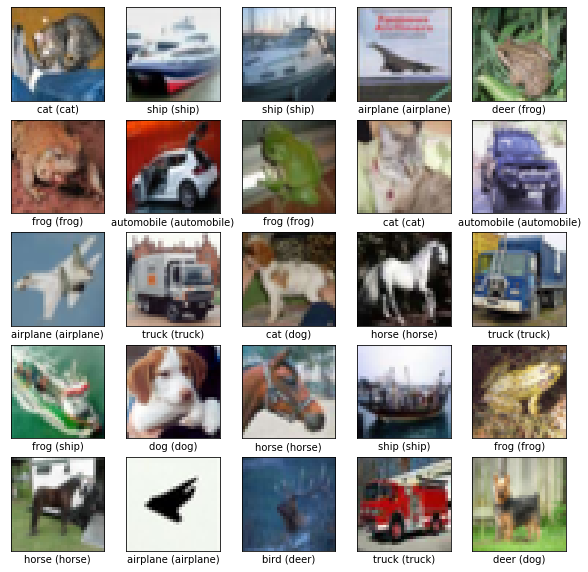

In [86]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel(class_names[labels_pred[i]] + f" ({class_names[test_labels[i][0]]})")
plt.show()

Overall, these results look fairly reasonable. There are plenty of mistakes, but it does look like the places where the model made errors are authentically somewhat confusing. A more complex or powerful model would potentially be able to do noticeably better on this data set. 

# Visualizing Learned Features 

It's possible to define a separate model that allows us to study the features learned by the model. These are often called *activations*. We create this model by simply asserting that the model outputs are equal to the outputs of the first convolutional layer. For this we use the `models.Model` class rather than the `models.Sequential` class, which is more convenient but less flexible. 

It's possible to look at the activations at different levels of the model. Generally speaking, it is expected that the activations become more abstract as one goes higher up the model structure. 

In [17]:
activation_model = models.Model(inputs=model.input, 
                                outputs=model.layers[0].output)

Check inputs and outputs layer by layer

In [18]:
model.input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_1_input')>

This is also the input of the first layer

In [19]:
model.layers[0].input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_1_input')>

The outut of the first layer is the input of the second layer

In [20]:
model.layers[0].output

<KerasTensor: shape=(None, 30, 30, 32) dtype=float32 (created by layer 'conv2d_1')>

In [21]:
model.layers[1].input

<KerasTensor: shape=(None, 30, 30, 32) dtype=float32 (created by layer 'conv2d_1')>

Now we can compute the activations

In [22]:
activations = activation_model.predict(train_images[0:10]) 

And visualize them! 

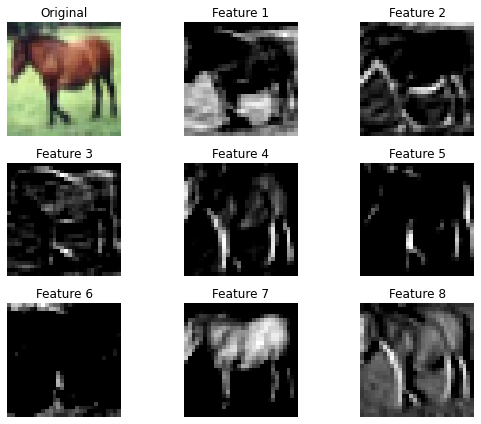

In [23]:
k = 7

color_im = train_images[k:(k+1)]
convd = conv(color_im).numpy()

fig, axarr = plt.subplots(3, 3, figsize = (8, 6))

axarr[0, 0].imshow(color_im[0])
axarr[0,0].axis("off")
axarr[0,0].set(title = "Original")

i = 0
for ax in axarr.flatten()[1:]:
    ax.imshow(activations[k,:,:,i], cmap = "gray")
    i += 1
    ax.axis("off")
    ax.set(title = "Feature " + str(i))
    
plt.tight_layout()

Somewhat romantically, these activations might be interpreted as "how the algorithm looks at" the resulting image. That said, one must be careful of over-interpretation. Still, it looks like some of the features correspond to edge detection (like we saw above), while others correspond to highlighting different patches of colors, enabling, for example, separation of the foreground object from the background. 

Further Reading:
    
https://cs231n.github.io/convolutional-networks/